Import Data and Image Resize

In [21]:
import os

# Set the working directory to the SNAKES folder on your desktop
os.chdir("/Users/jules/Desktop/SNAKES")

#confirm opened
print(os.listdir())

['.DS_Store', 'pantherophis-alleghaniensis', 'heterodon-platirhinos', 'diadophis-punctatus', 'coluber-constrictor', 'crotalus-atrox', 'agkistrodon-piscivorus', 'nerodia-fasciata']


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
!pip install matplotlib Pillow
import os
from PIL import Image
import matplotlib.pyplot as plt
path_to_folder = "pantherophis-alleghaniensis"
files_in_folder = os.listdir(path_to_folder)
image_files = [file for file in files_in_folder if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

if image_files:
    image_path = os.path.join(path_to_folder, image_files[0])  # This selects the first image file
else:
    print("No image files found in the folder")

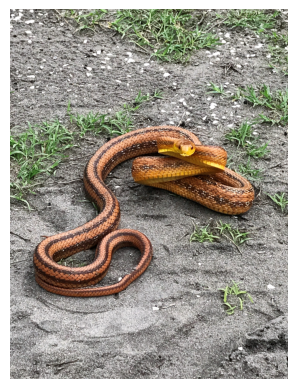

In [26]:
if image_files:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

In [27]:
# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image pixel values
    validation_split=0.2  # Assuming you want to split data for validation
)

# Specify the directory for training data and set parameters
train_generator = train_datagen.flow_from_directory(
    '/Users/jules/Desktop/SNAKES',  # Replace with your base directory
    target_size=(200, 200),  # Resize images to 200x200
    batch_size=32,  # Batch size (adjust as needed)
    class_mode='categorical',  # For multi-class classification
    subset='training'  # Specify subset as training
)

# Similarly, you can define a generator for validation data if needed
validation_generator = train_datagen.flow_from_directory(
    '/Users/jules/Desktop/SNAKES',  # Replace with your base directory
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.


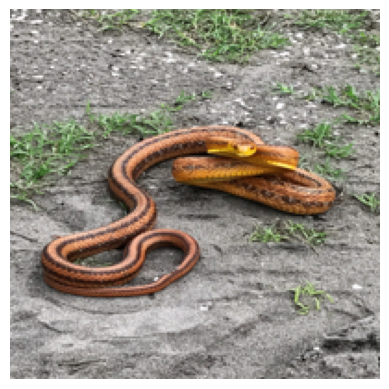

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the original image
image_path = os.path.join(path_to_folder, image_files[0])
original_img = Image.open(image_path)

# Resize the image to 200x200
resized_img = original_img.resize((200, 200))

# Convert the image to a numpy array and normalize it
normalized_img = np.array(resized_img) / 255.0

# Display the resized and normalized image
plt.imshow(normalized_img)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam, Adadelta, RMSprop

def Build_AlexNet_like_CNN(conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates, optimizer='Adam', learning_rate=0.001, input_shape=(200, 200, 3), num_classes=7):
    model = Sequential()

    # Add convolutional layers
    for i in range(len(conv_layers)):
        if i == 0:
            model.add(Conv2D(conv_layers[i], kernel_sizes[i], strides=strides[i], padding='valid', activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(conv_layers[i], kernel_sizes[i], padding='same', activation='relu'))

        model.add(MaxPooling2D(pool_sizes[i], strides=strides[i], padding='same'))
        model.add(BatchNormalization())

    # Flatten the output
    model.add(Flatten())

    # Add dense layers
    for i in range(len(dense_layers)):
        model.add(Dense(dense_layers[i], activation='relu'))
        if dropout_rates[i] > 0:
            model.add(Dropout(dropout_rates[i]))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with the specified optimizer
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'Adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'Nadam':
        opt = Nadam(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer. Please provide one of ['Adam', 'Adagrad', 'Nadam', 'Adadelta', 'RMSprop'].")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# Architecture parameters from HW5
conv_layers = [96, 256, 384, 384, 256]
dense_layers = [256, 256]
kernel_sizes = [(5, 5), (3, 3), (3, 3), (3, 3), (3, 3)]
pool_sizes = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
strides = [(2, 2), (2, 2), (1, 1), (1, 1), (2, 2)]
dropout_rates = [0.5, 0.5]

# Build and compile the model
model = Build_AlexNet_like_CNN(conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates, optimizer='Adam', learning_rate=0.001, input_shape=(200, 200, 3), num_classes=7)

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 49, 49, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 256)       0         
 g2D)                                                            
                                                        

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def CNN_Hyper_Parameter_Tuning_AlexNet(optimizers_names, learning_rates, batch_sizes, epochs, base_dir, input_shape, num_classes, num_replicates=2):
    best_avg_accuracy = 0.0
    all_avg_accuracy = np.zeros((len(optimizers_names), len(learning_rates), len(batch_sizes)))

    conv_layers = [96, 256, 384, 384, 256]  # # of filters for each conv layer
    kernel_sizes = [(5, 5), (3, 3), (3, 3), (3, 3), (3, 3)]  # kernel sizes for each conv layer
    pool_sizes = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]  # pooling sizes for each conv layer
    strides = [(2, 2), (2, 2), (1, 1), (1, 1), (2, 2)]  # strides for each conv and pooling layer
    dense_layers = [256, 256]  # dense layers configuration
    dropout_rates = [0.5, 0.5]  # dropout rates for each dense layer

    best_hyper_parameters = {
        "optimizer": None,
        "learning_rate": None,
        "batch_size": None,
        "best_avg_accuracy": None
    }

    for opt_name in optimizers_names:
        for lr in learning_rates:
            for bs in batch_sizes:
                # Reinitialize the ImageDataGenerators with the current batch size
                train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
                train_generator = train_datagen.flow_from_directory(
                    base_dir, target_size=input_shape[:2], batch_size=bs, class_mode='categorical', subset='training')
                validation_generator = train_datagen.flow_from_directory(
                    base_dir, target_size=input_shape[:2], batch_size=bs, class_mode='categorical', subset='validation')

                steps_per_epoch = np.ceil(train_generator.samples / bs)
                validation_steps = np.ceil(validation_generator.samples / bs)

                collect_accuracy = []
                for i in range(num_replicates):
                    print(f"Running for {opt_name} optimizer {lr} learning_rate {bs} batch_size and {i} replicate \n")

                    # Build the model
                    model = Build_AlexNet_like_CNN(conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates, optimizer=opt_name, learning_rate=lr, input_shape=input_shape, num_classes=num_classes)

                    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                    history = model.fit(
                        train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=[callback]
                    )
                    collect_accuracy.append(history.history['val_accuracy'][-1])

                avg_accuracy = np.mean(collect_accuracy)
                all_avg_accuracy[optimizers_names.index(opt_name)][learning_rates.index(lr)][batch_sizes.index(bs)] = avg_accuracy

                if avg_accuracy > best_avg_accuracy:
                    best_avg_accuracy = avg_accuracy
                    best_hyper_parameters = {
                        "optimizer": opt_name,
                        "learning_rate": lr,
                        "batch_size": bs,
                        "best_avg_accuracy": best_avg_accuracy
                    }

    output_dictionary = {
        "best_hyper_parameters": best_hyper_parameters,
        "all_avg_accuracy": all_avg_accuracy
    }

    print("Best_hyper_parameters(AlexNet CNN): \n", output_dictionary['best_hyper_parameters'])
    print("all_avg_accuracy(AlexNet CNN): \n", output_dictionary['all_avg_accuracy'])

    return output_dictionary['best_hyper_parameters']


In [33]:
# Parameters for hyperparameter tuning
optimizers_names = ['Adam']
learning_rates = [0.005]
batch_sizes = [16]
epochs = 1
num_replicates = 2

# Directory where your images are stored
base_dir = "/Users/jules/Desktop/SNAKES"

# Input shape and number of classes
input_shape = (200, 200, 3)  # images are 200x200 with 3 color channels
num_classes = 7  # number of classes you have

# Call the function with the correct parameters
alexnet_best_hyper_parameters = CNN_Hyper_Parameter_Tuning_AlexNet(
    optimizers_names, learning_rates, batch_sizes, epochs, base_dir, input_shape, num_classes, num_replicates
)
print(alexnet_best_hyper_parameters)


Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.
Running for Adam optimizer 0.005 learning_rate 16 batch_size and 0 replicate 

137/137 [==============================] - 274s 2s/step - loss: 32.6272 - accuracy: 0.1463 - val_loss: 2.3147 - val_accuracy: 0.1429
Running for Adam optimizer 0.005 learning_rate 16 batch_size and 1 replicate 

137/137 [==============================] - 257s 2s/step - loss: 37.1608 - accuracy: 0.1522 - val_loss: 1.9575 - val_accuracy: 0.1429
Best_hyper_parameters(AlexNet CNN): 
 {'optimizer': 'Adam', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.1428571492433548}
all_avg_accuracy(AlexNet CNN): 
 [[[0.14285715]]]
{'optimizer': 'Adam', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.1428571492433548}


In [34]:
# Parameters for hyperparameter tuning
optimizers_names = ['Nadam']
learning_rates = [0.005]
batch_sizes = [16]
epochs = 1
num_replicates = 2

# Directory where your images are stored
base_dir = "/Users/jules/Desktop/SNAKES"

# Input shape and number of classes
input_shape = (200, 200, 3)  # images are 200x200 with 3 color channels
num_classes = 7  # number of classes you have

# Call the function with the correct parameters
alexnet_best_hyper_parameters = CNN_Hyper_Parameter_Tuning_AlexNet(
    optimizers_names, learning_rates, batch_sizes, epochs, base_dir, input_shape, num_classes, num_replicates
)
print(alexnet_best_hyper_parameters)

Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.
Running for Nadam optimizer 0.005 learning_rate 16 batch_size and 0 replicate 

137/137 [==============================] - 275s 2s/step - loss: 24.8753 - accuracy: 0.1481 - val_loss: 2.3635 - val_accuracy: 0.1447
Running for Nadam optimizer 0.005 learning_rate 16 batch_size and 1 replicate 

137/137 [==============================] - 255s 2s/step - loss: 24.6806 - accuracy: 0.1431 - val_loss: 8.4127 - val_accuracy: 0.1612
Best_hyper_parameters(AlexNet CNN): 
 {'optimizer': 'Nadam', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.15293040871620178}
all_avg_accuracy(AlexNet CNN): 
 [[[0.15293041]]]
{'optimizer': 'Nadam', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.15293040871620178}


In [35]:
# Parameters for hyperparameter tuning
optimizers_names = ['Adagrad']
learning_rates = [0.005]
batch_sizes = [16]
epochs = 1
num_replicates = 2

# Directory where your images are stored
base_dir = "/Users/jules/Desktop/SNAKES"

# Input shape and number of classes
input_shape = (200, 200, 3)  # images are 200x200 with 3 color channels
num_classes = 7  # number of classes you have

# Call the function with the correct parameters
alexnet_best_hyper_parameters = CNN_Hyper_Parameter_Tuning_AlexNet(
    optimizers_names, learning_rates, batch_sizes, epochs, base_dir, input_shape, num_classes, num_replicates
)
print(alexnet_best_hyper_parameters)

Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.
Running for Adagrad optimizer 0.005 learning_rate 16 batch_size and 0 replicate 

137/137 [==============================] - 240s 2s/step - loss: 3.6635 - accuracy: 0.1531 - val_loss: 2.0030 - val_accuracy: 0.1447
Running for Adagrad optimizer 0.005 learning_rate 16 batch_size and 1 replicate 

137/137 [==============================] - 251s 2s/step - loss: 3.7252 - accuracy: 0.1618 - val_loss: 2.0044 - val_accuracy: 0.1758
Best_hyper_parameters(AlexNet CNN): 
 {'optimizer': 'Adagrad', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.16025641560554504}
all_avg_accuracy(AlexNet CNN): 
 [[[0.16025642]]]
{'optimizer': 'Adagrad', 'learning_rate': 0.005, 'batch_size': 16, 'best_avg_accuracy': 0.16025641560554504}


In [39]:
# Parameters for hyperparameter tuning
optimizers_names = ['Adagrad']
learning_rates = [0.001,0.005,0.01]
batch_sizes = [16,32,64]
epochs = 3
num_replicates = 2

# Directory where your images are stored
base_dir = "/Users/jules/Desktop/SNAKES"

# Input shape and number of classes
input_shape = (200, 200, 3)  # images are 200x200 with 3 color channels
num_classes = 7  # number of classes you have

# Call the function with the correct parameters
alexnet_best_hyper_parameters = CNN_Hyper_Parameter_Tuning_AlexNet(
    optimizers_names, learning_rates, batch_sizes, epochs, base_dir, input_shape, num_classes, num_replicates
)
print(alexnet_best_hyper_parameters)

Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.
Running for Adagrad optimizer 0.001 learning_rate 16 batch_size and 0 replicate 

Epoch 1/3
137/137 [==============================] - 211s 2s/step - loss: 2.5786 - accuracy: 0.1814 - val_loss: 2.0198 - val_accuracy: 0.1447
Epoch 2/3
137/137 [==============================] - 195s 1s/step - loss: 1.9562 - accuracy: 0.2459 - val_loss: 2.2017 - val_accuracy: 0.1502
Epoch 3/3
137/137 [==============================] - 224s 2s/step - loss: 1.8389 - accuracy: 0.2843 - val_loss: 2.2283 - val_accuracy: 0.2161
Running for Adagrad optimizer 0.001 learning_rate 16 batch_size and 1 replicate 

Epoch 1/3
137/137 [==============================] - 206s 1s/step - loss: 2.5481 - accuracy: 0.1842 - val_loss: 2.1039 - val_accuracy: 0.1502
Epoch 2/3
137/137 [==============================] - 192s 1s/step - loss: 2.0013 - accuracy: 0.2340 - val_loss: 2.0427 - val_accuracy: 0.1502
Epoch 3/3
137/137 [========================

Running for Adagrad optimizer 0.01 learning_rate 32 batch_size and 1 replicate 

Epoch 1/3
69/69 [==============================] - 190s 3s/step - loss: 3.9352 - accuracy: 0.1632 - val_loss: 2.0671 - val_accuracy: 0.1538
Epoch 2/3
69/69 [==============================] - 192s 3s/step - loss: 2.0235 - accuracy: 0.1718 - val_loss: 1.9429 - val_accuracy: 0.1813
Epoch 3/3
69/69 [==============================] - 192s 3s/step - loss: 1.9576 - accuracy: 0.1814 - val_loss: 1.9686 - val_accuracy: 0.1465
Found 2188 images belonging to 7 classes.
Found 546 images belonging to 7 classes.
Running for Adagrad optimizer 0.01 learning_rate 64 batch_size and 0 replicate 

Epoch 1/3
35/35 [==============================] - 189s 5s/step - loss: 3.4419 - accuracy: 0.1618 - val_loss: 1.9676 - val_accuracy: 0.1502
Epoch 2/3
35/35 [==============================] - 187s 5s/step - loss: 2.0249 - accuracy: 0.1828 - val_loss: 1.9659 - val_accuracy: 0.1557
Epoch 3/3
35/35 [==============================] - 191s

In [42]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
def Final_AlexNet_Model_Snake_Data(conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates, hyper_parameters, train_generator, validation_generator, epochs=5, num_replicates=10):
    print("Number of replicates:", num_replicates)
    accuracy_array = np.zeros(num_replicates)
    elapsed_time_array = np.zeros(num_replicates)

    models_history = []

    for i in range(num_replicates):
        print(f"Running replicate {i} ----->\n")

        # Build the model
        model = Build_AlexNet_like_CNN(conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates, optimizer=hyper_parameters['optimizer'], learning_rate=hyper_parameters['learning_rate'], input_shape=(200, 200, 3), num_classes=7)

        # Compile the model
        model.compile(optimizer=model.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        start = time.time()
        history = model.fit(
            train_generator,
            steps_per_epoch=np.ceil(train_generator.samples / hyper_parameters['batch_size']),
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=np.ceil(validation_generator.samples / hyper_parameters['batch_size']),
            callbacks=[callback]
        )
        end = time.time()
        elapsed_time = end - start

        models_history.append(history)

        # Calculate performance metrics
        accuracy_array[i] = history.history['val_accuracy'][-1]
        elapsed_time_array[i] = elapsed_time

    # Calculate average accuracy & elapsed time
    avg_accuracy = np.mean(accuracy_array)
    avg_elapsed_time = np.mean(elapsed_time_array)

    print("Average Validation Accuracy: {:.2f}%".format(avg_accuracy * 100))
    print("Average Elapsed Time: {:.2f} seconds".format(avg_elapsed_time))

    # Final performance metrics
    performance_metrics = {
        'scores': {'accuracy': accuracy_array, 'elapsed_time': elapsed_time_array},
        'avg_scores': {'accuracy': avg_accuracy, 'elapsed_time': avg_elapsed_time}
    }

    return performance_metrics, models_history


In [ ]:
# Define hyperparameters and architecture parameters
hyper_parameters = {'optimizer': 'Adagrad', 'learning_rate': 0.001, 'batch_size': 16}
conv_layers = [96, 256, 384, 384, 256]
dense_layers = [256, 256]
kernel_sizes = [(5, 5), (3, 3), (3, 3), (3, 3), (3, 3)]
pool_sizes = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
strides = [(2, 2), (2, 2), (1, 1), (1, 1), (2, 2)]
dropout_rates = [0.5, 0.5]
epochs = 10
num_replicates = 10  # Number of replicates for the final model

# Assuming train_generator and validation_generator are already defined and initialized
# Call the function to train the model and get performance metrics
performance_metrics, models_history = Final_AlexNet_Model_Snake_Data(
    conv_layers, dense_layers, kernel_sizes, pool_sizes, strides, dropout_rates,
    hyper_parameters, train_generator, validation_generator, epochs, num_replicates
)

# Print performance metrics
print("Performance Metrics:", performance_metrics)


Number of replicates: 10
Running replicate 0 ----->

Epoch 1/10
 59/137 [===========>..................] - ETA: 3:47 - loss: 2.5840 - accuracy: 0.1697